In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import Counter
%matplotlib inline

In [45]:
user_clustid = pd.read_csv('user_clustid_k25.csv')
book_year = pd.read_csv('book_year_1tag.csv')
ratings_books_idx = pd.read_csv('df_80u_10b.csv')
ratings_books = pd.read_csv('ratings_books_u80_b10.csv')

In [34]:
listbooks_ratings = list(set(ratings_books['book_id_gr']))
listbooks_ratings_idx = list(set(ratings_books['book_idx']))

In [35]:
listbooks_year = list(set(book_year['book_id']))
len(listbooks_year)

92803

In [36]:
ratings_books.head()

,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,user_idx,book_idx
0,1073,1,3,1,47970,146,157,0,624
1,1073,1,4,1,304687,146,49,0,1867
2,1073,1,3,1,149267,146,1954,0,1322
3,1073,1,3,1,140098,146,136,0,1276
4,1073,1,3,1,1773616,146,71,0,3473


In [46]:
book_year.head()

,average_rating,book_id,popular_shelves,publication_year
0,3.48,7203847,horror,2010.0
1,4.04,12182387,young-adult,NaN
2,3.80,20135365,dystopia,NaN
3,3.43,780918,historical-fiction,NaN
4,3.55,780912,historical-fiction,2005.0


In [47]:
book_year.rename(columns={'book_id':'book_id_gr', 'publication_year':'pub_year'}, inplace=True)

In [48]:
book_year.head(3)

,average_rating,book_id_gr,popular_shelves,pub_year
0,3.48,7203847,horror,2010.0
1,4.04,12182387,young-adult,NaN
2,3.80,20135365,dystopia,NaN


In [49]:
len(listbooks_ratings), max(listbooks_ratings_idx)

(10268, 10267)

In [50]:
# Get books publication year from books_sci-fi, matching book_id from rated and reviewed data
ratings_book_year = ratings_books[ratings_books['book_id_gr'].isin(listbooks_year)]

In [51]:
len(ratings_book_year)

65897

In [52]:
ratings_book_year = pd.merge(ratings_books, book_year, on='book_id_gr',)

In [53]:
ratings_book_year.head()

,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,user_idx,book_idx,average_rating,popular_shelves,pub_year
0,1073,1,3,1,47970,146,157,0,624,3.9,fantasy,2002.0
1,17408,1,3,1,47970,215,157,51,624,3.9,fantasy,2002.0
2,54366,1,4,1,47970,111,157,130,624,3.9,fantasy,2002.0
3,91057,1,4,1,47970,81,157,195,624,3.9,fantasy,2002.0
4,98248,1,4,1,47970,139,157,210,624,3.9,fantasy,2002.0


In [54]:
ratings_books.head()

,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,user_idx,book_idx
0,1073,1,3,1,47970,146,157,0,624
1,1073,1,4,1,304687,146,49,0,1867
2,1073,1,3,1,149267,146,1954,0,1322
3,1073,1,3,1,140098,146,136,0,1276
4,1073,1,3,1,1773616,146,71,0,3473


In [55]:
book_year[book_year['book_id_gr'] == 47970]

,average_rating,book_id_gr,popular_shelves,pub_year
20063,3.9,47970,fantasy,2002.0


In [26]:
list_years = list(set(ratings_book_year['pub_year']))

In [27]:
len(list_years)

15172

In [28]:
list_books = list(set(ratings_books['book_id_gr']))
len(list_books)

10268

In [56]:
user_clustid.head(3)

,user_idx,group
0,0,14
1,1,14
2,2,14


In [57]:
user_all = pd.merge(user_clustid, ratings_book_year, on='user_idx',)

In [58]:
user_all.head(4)

,user_idx,group,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,book_idx,average_rating,popular_shelves,pub_year
0,0,14,1073,1,3,1,47970,146,157,624,3.90,fantasy,2002.0
1,0,14,1073,1,4,1,304687,146,49,1867,3.92,fantasy,NaN
2,0,14,1073,1,3,1,149267,146,1954,1322,4.34,horror,NaN
3,0,14,1073,1,3,1,140098,146,136,1276,3.72,anthology,NaN


In [62]:
user_all.dropna(inplace=True)

In [64]:
gp14 = user_all[user_all['group'] == 14]

In [67]:
user_gp14 = list(set(gp14['user_idx']))

In [74]:
user_gp14_filtered = gp14.drop(gp14.columns[[1, 2, 3, 4, 5, 6, 7, 8, 10]], axis=1)

In [75]:
user_gp14_filtered.head(3)

,user_idx,book_idx,popular_shelves,pub_year
0,0,624,fantasy,2002.0
4,0,3473,urban-fantasy,2008.0
5,0,4001,fantasy,2009.0


In [122]:
user_gp14_filtered[(user_gp14_filtered['user_idx'] == 0) & (user_gp14_filtered['pub_year'] == 1999)]

,user_idx,book_idx,popular_shelves,pub_year
10,0,110,fiction,1999.0
43,0,2254,fantasy,1999.0
81,0,3098,fiction,1999.0


## Clustering with book years

In [128]:
count_user_year = user_gp14_filtered.groupby(['user_idx', 'pub_year']).size().reset_index(name ='year_count')
#df_year_user = pd.DataFrame({'user_idx':count_user_year.index, 'number_read':sum_read_user.values})

In [131]:
count_user_year.head(5)

,user_idx,pub_year,year_count
0,0,1973.0,1
1,0,1979.0,1
2,0,1980.0,1
3,0,1989.0,1
4,0,1990.0,1


In [173]:
print('The number of unique years is %d' %len(set(count_user_year.pub_year)))

The number of unique years is 56


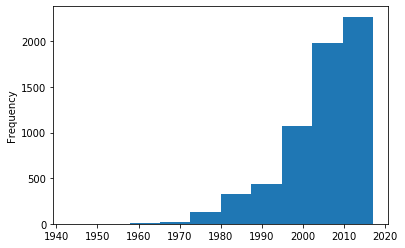

In [134]:
count_user_year['pub_year'].plot.hist()

In [148]:
test2 = pd.pivot_table(count_user_year, index='user_idx', columns= 'pub_year', values='year_count')

# Print the number of dimensions and a subset of the dataset
print('dataset dimensions: ', test2.shape, '\n\nSubset example:')
test2.iloc[:6, :10]

dataset dimensions:  (404, 56) 

Subset example:


pub_year,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0
user_idx,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
test2.fillna(0, inplace=True)

In [154]:
test2.shape

(404, 56)

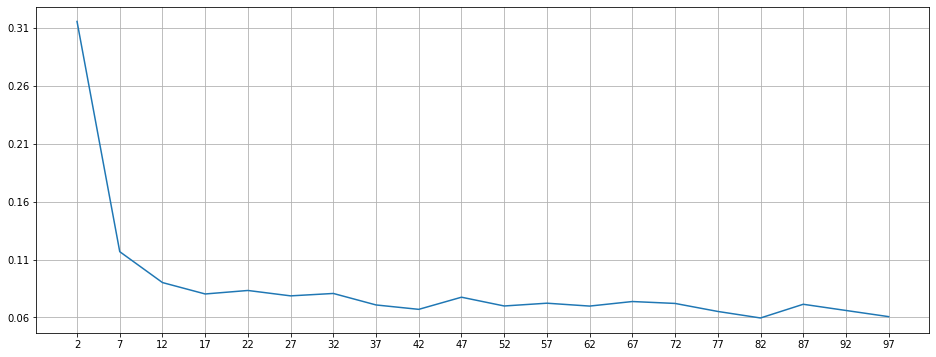

In [156]:
# Selecting our dataset to study
X = test2
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) 
    #for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values[:20], errors_per_k[:20])
# Ticks and grid
xticks = np.arange(min(possible_k_values[:20]), max(possible_k_values[:20])+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k[:20]), 2), max(errors_per_k[:20]), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [222]:
# 20 clusters
predictions = KMeans(n_clusters=10).fit_predict(test2)

# Cluster and print some of them
clustered = pd.concat([user_book_year.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [223]:
print(set(clustered['group'].values))
Counter(predictions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Counter({9: 52, 0: 45, 4: 91, 5: 65, 6: 16, 3: 63, 2: 28, 1: 20, 7: 8, 8: 16})

## Clustering with book years and book main subgenre

In [161]:
user_gp14_filtered.head(4)

,user_idx,book_idx,popular_shelves,pub_year
0,0,624,fantasy,2002.0
4,0,3473,urban-fantasy,2008.0
5,0,4001,fantasy,2009.0
9,0,273,fantasy,1973.0


In [162]:
count_user_tag = user_gp14_filtered.groupby(['user_idx', 'popular_shelves']).size().reset_index(name ='tag_count')

In [179]:
count_user_tag.head(5)

,user_idx,popular_shelves,tag_count
0,0,comics,17
1,0,dystopian,1
2,0,fantasy,12
3,0,fiction,10
4,0,graphic-novels,14


In [165]:
len(user_gp14_filtered[(user_gp14_filtered['user_idx'] == 0) & (user_gp14_filtered['popular_shelves'] == 'comics')])

17

In [175]:
print('The number of unique tags is %d' %len(set(count_user_tag.popular_shelves)))

The number of unique tags is 198


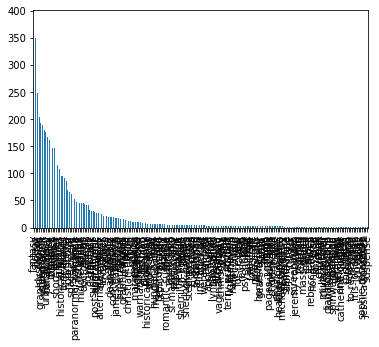

In [186]:
count_user_tag['popular_shelves'].value_counts().plot(kind='bar')

In [192]:
test2.head(4)

pub_year,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,5.0,4.0,15.0,5.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,10.0,10.0,4.0,5.0,1.0,1.0,3.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
listtags = Counter(count_user_tag['popular_shelves'])

In [206]:
listtags_freq = [k for k,v in listtags.items() if v>=10]

In [208]:
df_u_tags = count_user_tag[count_user_tag['popular_shelves'].isin(listtags_freq)]

In [209]:
df_u_tags.head(5)

,user_idx,popular_shelves,tag_count
0,0,comics,17
1,0,dystopian,1
2,0,fantasy,12
3,0,fiction,10
4,0,graphic-novels,14


In [210]:
test3 = pd.pivot_table(df_u_tags, index='user_idx', columns= 'popular_shelves', values='tag_count')

In [211]:
test3.head()

popular_shelves,adventure,aliens,alternate-history,angels,apocalyptic,bizarro,childhood,christian-fiction,classic,comics,...,superheroes,supernatural,thriller,time-travel,urban-fantasy,vampires,wake,warhammer-40k,young-adult,zombies
user_idx,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
test2.head()

pub_year,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,5.0,4.0,15.0,5.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,10.0,10.0,4.0,5.0,1.0,1.0,3.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,5.0,3.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0


In [213]:
tag_year = pd.merge(test2, test3, on='user_idx',)

In [216]:
tag_year.fillna(0, inplace=True)
tag_year.head(3)

,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0,...,superheroes,supernatural,thriller,time-travel,urban-fantasy,vampires,wake,warhammer-40k,young-adult,zombies
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [217]:
tag_year.shape

(404, 120)

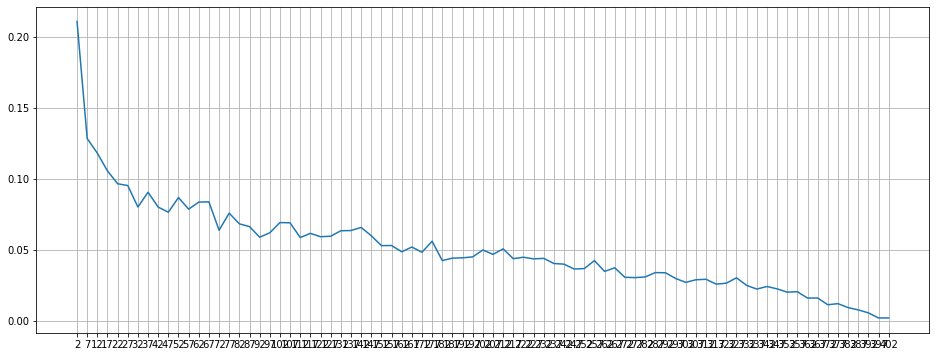

In [219]:
# Selecting our dataset to study
X = tag_year
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) 
    #for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg


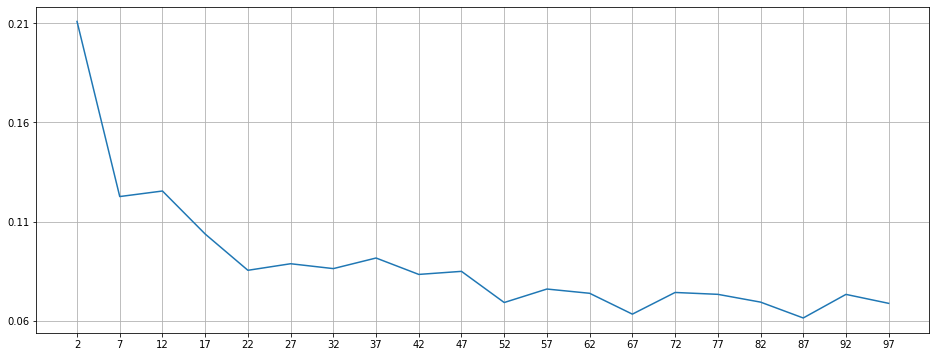

In [224]:

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values[:20], errors_per_k[:20])
# Ticks and grid
xticks = np.arange(min(possible_k_values[:20]), max(possible_k_values[:20])+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k[:20]), 2), max(errors_per_k[:20]), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [248]:
# 20 clusters
predictions = KMeans(n_clusters=12).fit_predict(tag_year)

# Cluster and print some of them
clustered_k12 = pd.concat([tag_year.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [249]:
print(set(clustered_k12['group'].values))
Counter(predictions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


Counter({1: 23,
         10: 31,
         9: 73,
         3: 61,
         7: 14,
         2: 43,
         6: 41,
         5: 26,
         11: 21,
         8: 5,
         4: 24,
         0: 42})

In [252]:
# 20 clusters
predictions = KMeans(n_clusters=7).fit_predict(tag_year)

# Cluster and print some of them
clustered_k7 = pd.concat([tag_year.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
print(set(clustered_k7['group'].values))
Counter(predictions)

{0, 1, 2, 3, 4, 5, 6}


Counter({1: 36, 3: 30, 0: 111, 4: 95, 6: 40, 5: 61, 2: 31})

## Now sub-clustering from each main clustering previously identified

In [227]:
user_clustid.head(3)

,user_idx,group
0,0,14
1,1,14
2,2,14


In [230]:
count_user_clust = user_clustid.groupby(['group']).size().reset_index(name ='gp_count')

In [232]:
count_user_clust

,group,gp_count
0,0,1
1,1,1
2,2,3
3,3,1
4,4,211
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


## Now testing with all groups with more than 10 users

In [233]:
def clust_group(dfin, clustid):
    df_clust = dfin[dfin['group'] == clustid]
    df_clust_filtered = df_clust.drop(gp14.columns[[1, 2, 3, 4, 5, 6, 7, 8, 10]], axis=1)  
    
    count_user_year = df_clust_filtered.groupby(['user_idx', 'pub_year']).size().reset_index(name ='year_count')
    user_year_pivot = pd.pivot_table(count_user_year, index='user_idx', columns= 'pub_year', values='year_count')
    
    count_user_tag = df_clust_filtered.groupby(['user_idx', 'popular_shelves']).size().reset_index(name ='tag_count')
    listtags = Counter(count_user_tag['popular_shelves'])
    listtags_freq = [k for k,v in listtags.items() if v>=10]
    df_u_tags = count_user_tag[count_user_tag['popular_shelves'].isin(listtags_freq)]
    user_tag_pivot = pd.pivot_table(df_u_tags, index='user_idx', columns= 'popular_shelves', values='tag_count')

    tag_year = pd.merge(user_year_pivot, user_tag_pivot, on='user_idx')
    tag_year.fillna(0, inplace=True)

    return tag_year


In [235]:
#gp4 = user_all[user_all['group'] == 4]

In [237]:
tag_year_gp4 = clust_group(user_all, 4)

In [238]:
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

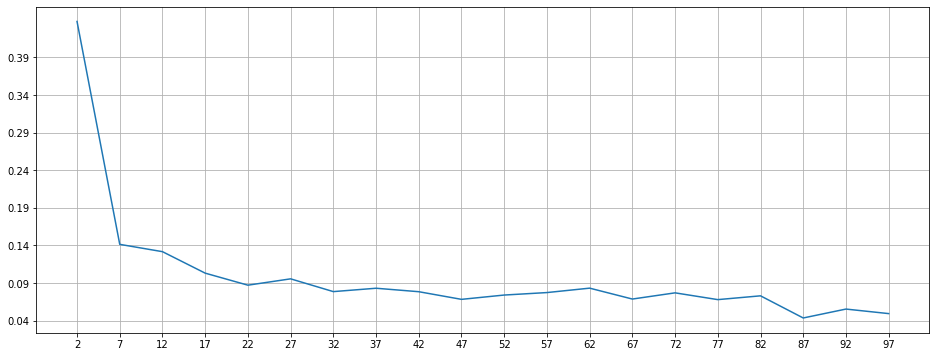

In [239]:
# Selecting our dataset to study
X = tag_year_gp4
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values[:20], errors_per_k[:20])
# Ticks and grid
xticks = np.arange(min(possible_k_values[:20]), max(possible_k_values[:20])+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k[:20]), 2), max(errors_per_k[:20]), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [240]:
predictions = KMeans(n_clusters=12).fit_predict(tag_year_gp4)

# Cluster and print some of them
clustered_gp4 = pd.concat([tag_year_gp4.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
Counter(predictions)

Counter({11: 38,
         0: 64,
         1: 7,
         5: 10,
         4: 7,
         3: 19,
         7: 27,
         2: 8,
         9: 21,
         10: 4,
         8: 3,
         6: 3})

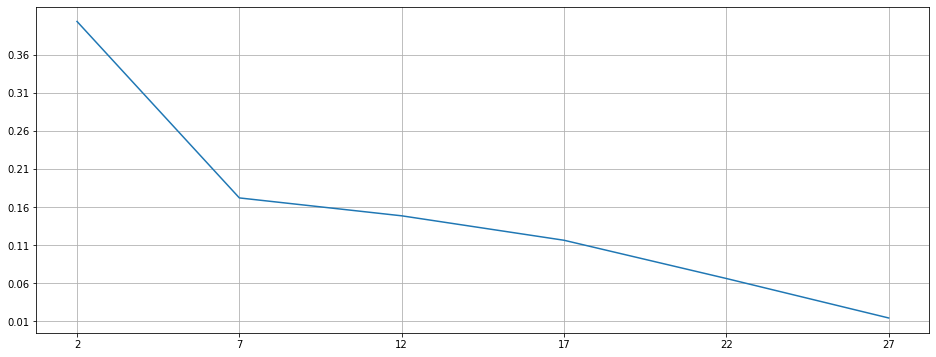

In [245]:
tag_year_gp11 = clust_group(user_all, 11)
# Selecting our dataset to study
X = tag_year_gp11
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [270]:
predictions = KMeans(n_clusters=2).fit_predict(tag_year_gp11)

# Cluster and print some of them
clustered_gp11 = pd.concat([tag_year_gp11.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
Counter(predictions)

Counter({1: 23, 0: 5})

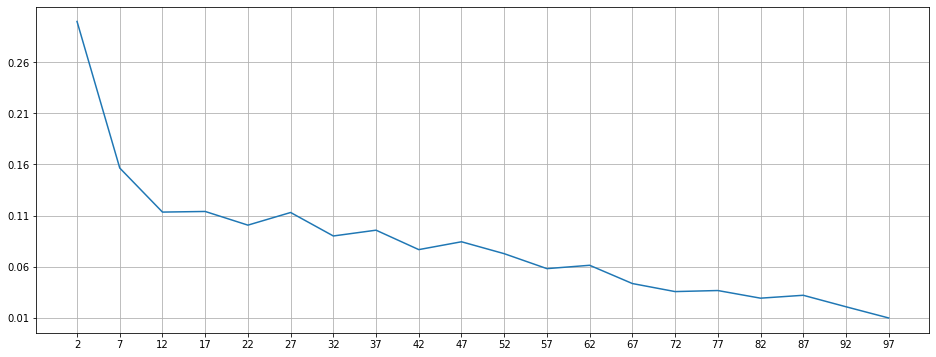

In [246]:
tag_year_gp12 = clust_group(user_all, 12)
# Selecting our dataset to study
X = tag_year_gp12
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [271]:
predictions = KMeans(n_clusters=7).fit_predict(tag_year_gp12)

# Cluster and print some of them
clustered_gp12 = pd.concat([tag_year_gp12.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
Counter(predictions)

Counter({6: 22, 1: 20, 3: 20, 2: 15, 0: 8, 4: 14, 5: 1})

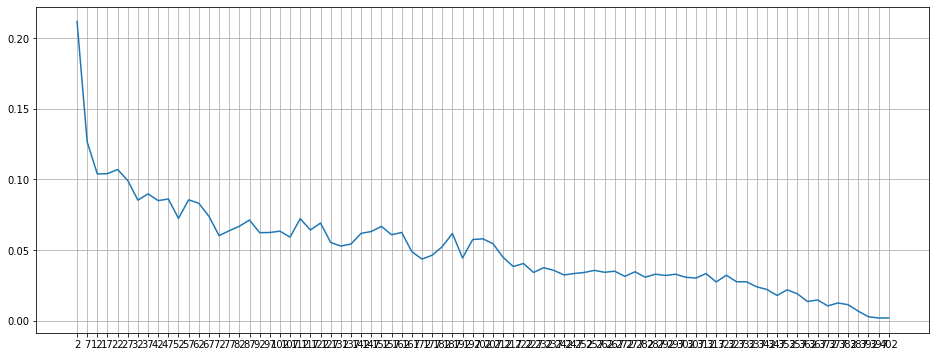

In [247]:
tag_year_gp14 = clust_group(user_all, 14)
# Selecting our dataset to study
X = tag_year_gp14
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

## Testing some clusters

In [265]:
clustered_gp4.head(25)

,user_idx,1937.0,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,...,steampunk,superheroes,thriller,time-travel,urban-fantasy,vampires,writing,young-adult,zombies,group
0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,11
1,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,14.0,2.0,0.0,0.0,3.0,0
2,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,3.0,0.0,1.0,0.0,14.0,2.0,1
4,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,2.0,0.0,17.0,1.0,0.0,0.0,3.0,5
5,36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,4
6,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,1.0,1
7,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,3
8,51,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,3
9,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,2.0,7


In [272]:
clustered_gp11.head(25)

,user_idx,1956.0,1973.0,1980.0,1981.0,1984.0,1986.0,1987.0,1988.0,1989.0,...,series,short-stories,steampunk,supernatural,time-travel,urban-fantasy,vampires,young-adult,zombies,group
0,24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,1.0,1.0,0.0,4.0,5.0,1.0,1
1,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,2.0,1.0,3.0,3.0,2.0,5.0,1.0,1
2,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,1.0,1.0,0.0,4.0,14.0,0.0,1
3,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,7.0,0.0,1.0,2.0,2.0,16.0,2.0,0
4,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,3.0,0.0,7.0,5.0,4.0,17.0,4.0,0
5,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,6.0,0.0,1.0,0.0,4.0,14.0,4.0,1
6,122,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,4.0,0.0,3.0,0.0,1.0,14.0,2.0,1
7,139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,15.0,0.0,1
8,197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,1.0,2.0,5.0,1.0,5.0,1.0,1
9,304,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,1.0,8.0,1.0,6.0,0.0,1


In [266]:
gp4_gb = clustered_gp4.groupby('group').agg({'%s':'sum' %steampunck})

NameError: name 'steampunck' is not defined

In [264]:
gp4_gb

,steampunk
group,
0,118.0
1,27.0
2,6.0
3,104.0
4,3.0
5,67.0
6,18.0
7,29.0
8,7.0


In [261]:
Counter(clustered_gp4['group'])

Counter({11: 38,
         0: 64,
         1: 7,
         5: 10,
         4: 7,
         3: 19,
         7: 27,
         2: 8,
         9: 21,
         10: 4,
         8: 3,
         6: 3})